# Logistic Regression

### Import libraries

In [1]:
import pandas as pd # one-hot encoding
import numpy as np
import glob
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

import joblib
import datetime

from collections import defaultdict

import sklearn
from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

### Import data

We work with 1956 comments from 5 different YouTube videos. The [YouTube Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#) is freely available.

In [2]:
path = r"data/YouTube-Spam-Collection/"
files = glob.glob(os.path.join(path, "*.csv"))

corpus = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
corpus.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [3]:
assert len(corpus) == 1956

### Statistics about the data

Data types:
COMMENT_ID    object
AUTHOR        object
DATE          object
CONTENT       object
CLASS          int64
dtype: object

There are 2 comment types: [1 0]
The dataset contains of 1956 examples: 1005 spam and 951 legitimate comments


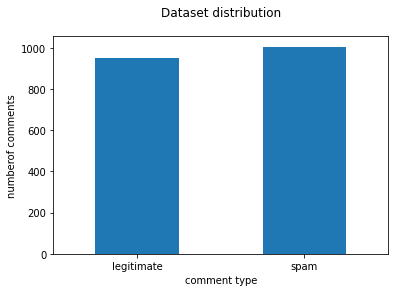

In [4]:
print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

corpus.groupby("CLASS").CONTENT.count().plot.bar(ylim=0)
plt.xticks([0,1],['legitimate', 'spam'], rotation=0)
plt.xlabel("comment type")
plt.ylabel("numberof comments")
plt.title("Dataset distribution", pad=20)
plt.show()

### Peprocessing

In [5]:
#nltk.download('stopwords')
#nltk.download('omw-1.4')
    
def preprocess_data(corpus,
                    irrelevant_features=["COMMENT_ID", "AUTHOR", "DATE"],
                    #rename_columns={"CONTENT":"COMMENT"}
                   ):
    
    # drop irrelevant features
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # remove blank rows if any
    corpus.dropna()
    
    # add column for representation
    corpus['REPR'] = corpus.loc[:, 'CONTENT']
        
    # lower case
    corpus['REPR'] = corpus['REPR'].str.lower()

    # change column name
    #for old, new in rename_columns:
        #corpus.rename({old : new}, axis=1, inplace=True)

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    
    for comment in corpus["REPR"]:    
        comment = nltk.word_tokenize(comment) # tokenizing nltk.WordPunctTokenizer().tokenize(comment.lower())?
        comment = [lemmatizer.lemmatize(word) for word in comment] # lemmatizing
        comment = [word for word in comment if word not in stop_words] # removing stopwords
        comment = " ".join(comment)

In [6]:
preprocess_data(corpus)

# binary feature representation
vectorizer = CountVectorizer(binary=True, max_df=0.95) #max_features=10000, tokenizer=lambda doc: doc)
BOW = vectorizer.fit_transform(corpus["REPR"])

# count based feature representation
vectorizer_2 = CountVectorizer(binary=False, max_df=0.95) #max_features=10000)
BOW_2 = vectorizer_2.fit_transform(corpus["REPR"])

# bag of 2-Grams
bigram_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
BOW_3 = bigram_vectorizer.fit_transform(corpus["REPR"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95) #min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
tfidf_voc = tfidf_vectorizer.fit_transform(corpus["REPR"])

### Logistic Regression model

### Train, store and evaluate

In [7]:

def split_data(features, labels):
    return train_test_split(features,labels, test_size=0.3,random_state=42,shuffle=True)


def save_model(model):
    now = datetime.datetime.now()
    model_output_path = "saved_models/"+model.__class__.__name__.lower()+"_"+str(now.minute)+"-"+str(now.second)+".joblib"
    joblib.dump(model, open(model_output_path, 'wb+'))


def report(model, best_model, X_test, y_test, labels):
    print(f"Best parameters set {model.best_params_} with accuracy {model.best_score_}")
    y_predict = best_model.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
    print("Precision: {}%".format(sklearn.metrics.precision_score(y_test, y_predict)*100))
    print("Recall: {}%".format(sklearn.metrics.recall_score(y_test, y_predict)*100))

    
def train_lg_classifier(features, labels):
    # split data
    X_train, X_test, y_train, y_test = split_data(features, labels)

    param = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

    clf = GridSearchCV(LogisticRegression(), param, cv=5, n_jobs=2, verbose=0)
    
    clf.fit(X_train, y_train)
    lg_clf = clf.best_estimator_
    
    # save model to disk
    save_model(lg_clf)
    
    # show test report
    report(clf, lg_clf, X_test, y_test, labels)


Best parameters set {'C': 100.0} with accuracy 0.9532552605545307

Confusion matrix:


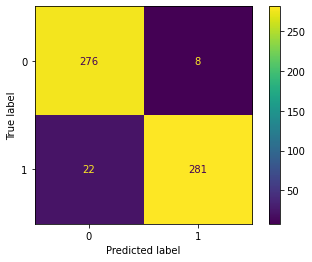


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       284
           1       0.97      0.93      0.95       303

    accuracy                           0.95       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.95      0.95      0.95       587


Accuracy: 94.8892674616695%
Precision: 97.23183391003461%
Recall: 92.73927392739274%


In [8]:
train_lg_classifier(BOW, np.asarray(corpus["CLASS"]))

Best parameters set {'C': 10.0} with accuracy 0.9525333547231357

Confusion matrix:


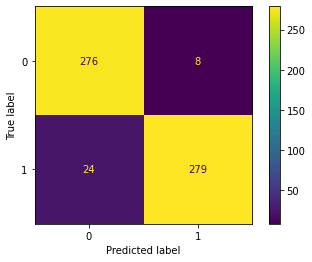


Classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       284
           1       0.97      0.92      0.95       303

    accuracy                           0.95       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.95      0.95      0.95       587


Accuracy: 94.54855195911414%
Precision: 97.21254355400697%
Recall: 92.07920792079209%


In [9]:
train_lg_classifier(BOW_2, np.asarray(corpus["CLASS"]))

/home/vivi/uni/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters set {'C': 10.0} with accuracy 0.9371861714927409

Confusion matrix:


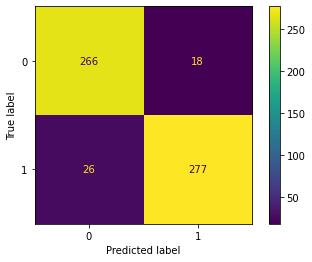


Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       284
           1       0.94      0.91      0.93       303

    accuracy                           0.93       587
   macro avg       0.92      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587


Accuracy: 92.50425894378195%
Precision: 93.89830508474576%
Recall: 91.41914191419141%


In [10]:
train_lg_classifier(BOW_3, np.asarray(corpus["CLASS"]))

Best parameters set {'C': 100.0} with accuracy 0.9474158444961365

Confusion matrix:


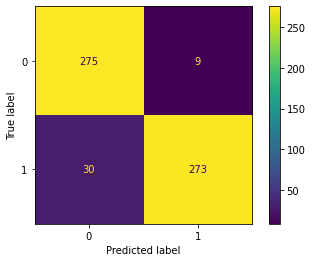


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       284
           1       0.97      0.90      0.93       303

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.94      0.93      0.93       587


Accuracy: 93.35604770017035%
Precision: 96.80851063829788%
Recall: 90.0990099009901%


In [11]:
train_lg_classifier(tfidf_voc, np.asarray(corpus["CLASS"]))

### Load saved model

In [12]:
model_output_path = 'saved_models/logisticregression_34-12.joblib'

def load_saved_model(model_path):
    return joblib.load(model_path)

In [13]:
clf = load_saved_model(model_output_path)
X_train, X_test, y_train, y_test = split_data(tfidf_voc, np.asarray(corpus["CLASS"]))

In [14]:
pd.DataFrame(clf.predict_proba(X_test[0]), columns=clf.classes_)

,0,1
0,0.99623,0.00377
